# ASTR 598 Astrostatistics, HW4


In [1]:
#importing all packages
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits

Steps : 
    
   * [cross-match the NSC-HLC S82 catalog](#hlc-nsc)
   * [load the SDSS DR14 QSO catalog, select S82 footprint](#add qso)
    * cross-match with NSC-HLC data to form a  training set
    * treat the rest of NSC-HLC as a test set 

# HLC-NSC crossmatch <a id='hlc-nsc'></a>

[Go to top](#toc)

NOTE:  do that only once, it takes about 10 mins.

In [2]:
test_for_catalogs = [s for s in os.listdir() if s.startswith('hlc_nsc_')]
if len(test_for_catalogs) > 0 : 
    print('There are following files that look like cross-matched HLC-NSC catalogs:')
    print(test_for_catalogs)
    print('You may go to the next step')
else : 
    print('I do not see any files that start with "hlc_nsc*" that could be \
cross-matched HLC-NSC catalogs ... ')

I do not see any files that start with "hlc_nsc*" that could be cross-matched HLC-NSC catalogs ... 


In [3]:
# Load the NSC data ... 
table_neg = Table.read('HW_2/NSC_stripe82_Dec_negative.csv')
table_pos = Table.read('HW_2/NSC_stripe82_Dec_positive.csv')

In [4]:
# Stack the two tables vertically 
nsc = vstack([table_neg, table_pos])
print('Done')

Done


In [5]:
# Rename NSC cols, adding an appropriate prefix 
nsc_colnames = nsc.colnames
nsc_new_colnames = ['NSC'+c for c in nsc_colnames]
for old_col,new_col  in zip(nsc_colnames, nsc_new_colnames):
    nsc.rename_column(old_col, new_col)
    

In [6]:
# Wrap the ra around 180 so it's easier to split into few groups by RA 
nsc['NSCraW'] = np.where(nsc['NSCra']>180, nsc['NSCra']-360, nsc['NSCra'])

In [7]:
# Read in the HLC data : 
catalogs = ['HLC.RA_20_to_21.fits.gz',
'HLC.RA_21_to_22.fits.gz',
'HLC.RA_22_to_23.fits.gz',
'HLC.RA_23_to_24.fits.gz',
'HLC.RA_00_to_01.fits.gz',
'HLC.RA_01_to_02.fits.gz',
'HLC.RA_02_to_03.fits.gz',
'HLC.RA_03_to_04.fits.gz']

def ReadTable(name):
    dir_hlc = 'HW_1/'
    hlc_fits = fits.open(dir_hlc+name)
    hlc_table = Table(hlc_fits[1].data)
    return hlc_table

hlc = ReadTable(catalogs[0])
for catalog in catalogs[1:] : 
    print('Reading ', catalog)
    hlc_cat = ReadTable(catalog)
    hlc = vstack([hlc, hlc_cat])

print('Done reading HLC data')


Reading  HLC.RA_21_to_22.fits.gz
Reading  HLC.RA_22_to_23.fits.gz
Reading  HLC.RA_23_to_24.fits.gz
Reading  HLC.RA_00_to_01.fits.gz
Reading  HLC.RA_01_to_02.fits.gz
Reading  HLC.RA_02_to_03.fits.gz
Reading  HLC.RA_03_to_04.fits.gz
Done reading HLC data


In [9]:
# Since S82 is centered on RA=0 , stretching roughly +/- 50 degrees away
# it makes sense to change 0-360 to -180 / +180 .. 
coord= 'RA'
for col_type in  ['_MEAN','_MEAN_CLIP']:    
    c =coord+col_type
    hlc[c +'_W'] = np.where(hlc[c]>180, hlc[c]-360, hlc[c])

In [10]:
# Add appropriate prefix 
hlc_colnames = hlc.colnames
hlc_new_colnames = ['HLC_'+c for c in hlc_colnames]
for old_col,new_col  in zip(hlc_colnames, hlc_new_colnames):
    hlc.rename_column(old_col, new_col)
    
# Rename HLC cols, cast ugriz onto cols
# add the mag, magerr cols so that all is a one table...
magcols = ['HLC'+f+'mag' for f in 'ugriz' ]
magerrcols=  ['HLC'+f + 'err' for f in 'ugriz' ]

# Cast the compressed mag, magerr HLC columns 
# onto tables that we then stack horizontally (along columns)
mean_psfmag = Table(hlc['HLC_MEAN_PSFMAG_CLIP'], names=(magcols))
mean_psfmagerr = Table(hlc['HLC_MEAN_PSFMAG_ERR_CLIP'], names=(magerrcols))
mean_magerr = hstack([mean_psfmag, mean_psfmagerr])

# and finally add the mag-err table to the original hlc-nsc table 
hlc = hstack([mean_magerr, hlc])


Select only needed columns for cross-matching ... 

In [16]:
#print(np.ravel(hlc.colnames))
cols = ['HLCumag' ,'HLCgmag' ,'HLCrmag', 'HLCimag' ,'HLCzmag', 'HLCuerr' ,'HLCgerr',
        'HLCrerr', 'HLCierr', 'HLCzerr' ,'HLC_LC_NAME',
        'HLC_MEAN_OBJECT_TYPE', 'HLC_RA_MEAN_CLIP_W', 
        'HLC_MEAN_CHILD','HLC_REDDENING', 'HLC_DEC_MEAN_CLIP']
hlc = hlc[cols]

Note : there is more NSC than HLC sources, so it makes sense to match HLC to NSC ( in the hope that every HLC source would have a match within more numerous NSC catalog ).



In [17]:
print('length of NSC catalog: ', len(nsc))
print('length of HLC catalog: ', len(hlc))

length of NSC catalog:  7409326
length of HLC catalog:  3700548


To make cross-matching faster, split the RA range into 10 bins of RA from -50 to +50 degrees : 

In [18]:
hlc_ra_col  = 'HLC_RA_MEAN_CLIP_W' # choose which ra,dec type to use for HLC 
hlc_dec_col = 'HLC_DEC_MEAN_CLIP'

nsc_ra_col = 'NSCraW'
nsc_dec_col = 'NSCdec'

hlc_nsc = Table()
ra = np.arange(-50,60,10)
for i in range(len(ra)-1):
    print('Matching ra in range ',ra[i], ra[i+1])
    mask_hlc = (ra[i]<hlc[hlc_ra_col])*(hlc[hlc_ra_col] < ra[i+1])
    mask_nsc = (ra[i]<nsc[nsc_ra_col])*(nsc[nsc_ra_col] < ra[i+1])
    
    hlc_sel = hlc[mask_hlc]
    nsc_sel = nsc[mask_nsc]
    
    hlc_coords = SkyCoord(ra=hlc_sel[hlc_ra_col]*u.degree, 
                          dec=hlc_sel[hlc_dec_col]*u.degree
                         )
    nsc_coords = SkyCoord(ra = nsc_sel[nsc_ra_col]*u.degree,  
                          dec = nsc_sel[nsc_dec_col]*u.degree
                         )
    
    idx, d2d, d3d = hlc_coords.match_to_catalog_sky(nsc_coords)  
    
    hlc_nsc_sel = hstack([hlc_sel, nsc_sel[idx]], table_names = ['hlc', 'nsc'])
    hlc_nsc_sel['sep_2d_arcsec_HLC_NSC'] = d2d.arcsec
    
    hlc_nsc = vstack([hlc_nsc_sel, hlc_nsc])
    
print('Finished crossmatching')    

Matching ra in range  -50 -40
Matching ra in range  -40 -30
Matching ra in range  -30 -20
Matching ra in range  -20 -10
Matching ra in range  -10 0
Matching ra in range  0 10
Matching ra in range  10 20
Matching ra in range  20 30
Matching ra in range  30 40
Matching ra in range  40 50
Finished crossmatching


In [19]:
# How many of the hlc sources had a good match ? 
mask_d2d = hlc_nsc['sep_2d_arcsec_HLC_NSC'] < 0.5
print('Of all ',len(hlc), ' HLC sources, ', np.sum(mask_d2d), 
      ' have an NSC match within 0.5 arcsec')

Of all  3700548  HLC sources,  2720047  have an NSC match within 0.5 arcsec


In [20]:
# Make sure that there are no 'multiple' sources : those in NSC that correspond to 
# more than one HLC source. Print their number , and remove them 
matched  =  hlc_nsc['sep_2d_arcsec_HLC_NSC'] < 0.5
selected =  hlc_nsc[matched]

values, counts  = np.unique(selected[nsc_dec_col], return_counts=True)
multiples = selected[np.in1d(selected[nsc_dec_col], values[counts>1])]

# Remove the multiples
select= selected[~np.in1d(selected[nsc_dec_col], values[counts>1])]

In [22]:
# Since the above steps take quite a while, save the cross-matched table 
# with good matches ... 
fname = 'hlc_nsc_half_arcsec'
np.save(fname,select)
print('Saving the cross-matched catalog as ', fname )

Saving the cross-matched catalog ] columns as  hlc_nsc_half_arcsec


# Make QSO HLC-NSC-SDSS training set  <a id='add qso'></a>

[Go to top](#toc)

We load the cross-matched HLC-NSC catalog, and add the SDSS DR14 QSO

In [2]:
# Load the cross-matched HLC-NSC catalog
fname =  'hlc_nsc_half_arcsec.npy'
hlc_nsc = Table(np.load(fname))

In [3]:
# Load the QSO DR14 
hdu = fits.open('DR14Q_v4_4.fits')
dr14_data = Table(hdu[1].data)


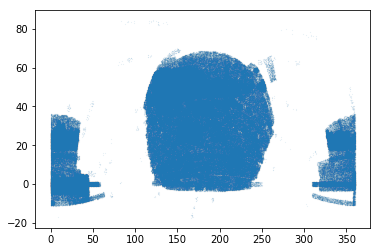

In [4]:
dr14 = dr14_data.copy()

# This is the entire SDSS footprint ...
plt.scatter(dr14['RA'], dr14['DEC'], s=0.001)

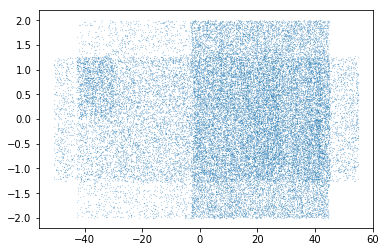

In [5]:
# Select only S82 , since we only have NSC_HLC data for S82

# re-express the ra from 0-360 to +/- 180 ..
dr14['RA_W'] = np.where(dr14['RA']>180, dr14['RA']-360, dr14['RA'])

# Plot only the selection 
m1 = np.abs(dr14['DEC']) < 2
m2 = np.abs(dr14['RA_W']) < 55
m = m1*m2
dr14_sel = dr14[m]
plt.scatter(dr14_sel['RA_W'], dr14_sel['DEC'], s=0.01)

In [6]:
# add the mag, magerr cols so that all is a one table...
magcols = [f+'magSDSS' for f in 'ugriz' ]
magerrcols=  [f + 'errSDSS' for f in 'ugriz' ]

# Cast the compressed mag, magerr HLC columns 
# onto tables that we then stack horizontally (along columns)
mean_psfmag = Table(dr14_sel['PSFMAG'], names=(magcols))
mean_psfmagerr = Table(dr14_sel['ERR_PSFMAG'], names=(magerrcols))
mean_magerr = hstack([mean_psfmag, mean_psfmagerr])

# and finally add the mag-err table to the original hlc-nsc table 
dr14_sel = hstack([mean_magerr, dr14_sel])

# then remove these compresessed , no-longer-needed columns from
# the original table
dr14_sel.remove_columns(['PSFMAG','ERR_PSFMAG'])

In [8]:
rmin, rmax = 17,20
m_r = (rmin < dr14_sel['rmagSDSS']) * (dr14_sel['rmagSDSS'] < rmax)
print('There are  ', np.sum(m_r), ' qso within ', rmin, '< rmag <', rmax)

There are   8114  qso within  17 < rmag < 20


The number looks good - it's slightly higher than the combined DR9-DR12 (6455), as we would expect. 

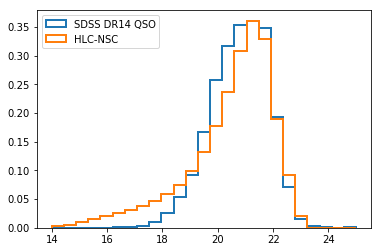

In [25]:
plt.hist(dr14_sel['rmagSDSS'],normed=True, range=(14,25), bins=25, 
         histtype='step', lw=2, label='SDSS DR14 QSO')
plt.hist(hlc_nsc['NSCrmag'], normed=True,range=(14,25), bins=25,
         histtype='step',lw=2, label='HLC-NSC')
plt.legend(loc='upper left')

Use NSC coords to cross-match 

In [37]:
hlc_nsc_qso = Table()
ra = np.arange(-50,60,10)

cat1 = dr14_sel
cat2 = hlc_nsc
ra1col , dec1col = 'RA_W', 'DEC'
ra2col , dec2col  = 'NSCraW', 'NSCdec'

# Match catalog 1 to catalog 2 splitting in the RA range 
for i in range(len(ra)-1):
    print('Matching ra in range ',ra[i], ra[i+1])
    m1 = (ra[i]<cat1[ra1col])*(cat1[ra1col] < ra[i+1])
    m2 = (ra[i]<cat2[ra2col])*(cat2[ra2col] < ra[i+1])
    
    cat1_part = cat1[m1] 
    cat2_part = cat2[m2]
    
    coords1 = SkyCoord(ra = cat1_part[ra1col]*u.degree, 
                      dec = cat1_part[dec1col]*u.degree) 
    
    coords2 = SkyCoord(ra = cat2_part[ra2col]*u.degree, 
                      dec = cat2_part[dec2col]*u.degree) 
    
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)  
    
    cat12_part = hstack([cat1_part, cat2_part[idx]])
    cat12_part['sep_2d_arcsec_NSC_SDSS'] = d2d.arcsec
     
    hlc_nsc_qso = vstack([cat12_part, hlc_nsc_qso])
    
print('Finished crossmatching')    

Matching ra in range  -50 -40
Matching ra in range  -40 -30
Matching ra in range  -30 -20
Matching ra in range  -20 -10
Matching ra in range  -10 0
Matching ra in range  0 10
Matching ra in range  10 20
Matching ra in range  20 30
Matching ra in range  30 40
Matching ra in range  40 50
Finished crossmatching


In [65]:
hlc_nsc_qso

<Table length=0>
<No columns>

In [64]:
x = hlc_nsc_qso['sep_2d_arcsec_NSC_SDSS']
radius = 0.2 
plt.hist(x[x<radius])
print('Found a match for ',np.sum(x<radius), '/',len(x),' DR14 QSO within ',
      radius, 'arcsec')

KeyError: 'sep_2d_arcsec_HLC_NSC_SDSS'

In [48]:
# Save the cross-matched SDSS - NSC - HLC 
fname = 'hlc_nsc_sdss_qso_matches'
np.save(fname, hlc_nsc_qso[x<0.2],)

Next : 
   * cross-match DR14 QSO in S82 to the NSC-HLC catalog 
   * save that as a training set 
   * use K-nearest neighbors to estimate density in color-color space (eg u-g vs g-r)  ( Fig. 6.4,  also Week-8-Tue lecture, chapter 6.2 in the Yellow Book ) 
   * classification with KNN - chapter 9.4 in the Yellow Book 
   * Classification: chapter 9 in the Yellow Book 
   * use Naive Bayes for classification: chapter 9.3.2 
   * use decision trees for classificaion: chapter 9.7 
   * Evaluating: chapter 9.8 on ROC Curves 
   * See Fig. 9.18 http://www.astroml.org/book_figures/chapter9/fig_star_quasar_ROC.html 

# Make Stars HLC-NSC training set 

Use the SDSS standard stars catalog :
    

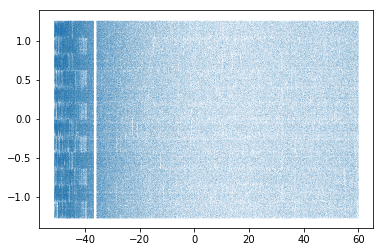

In [50]:
import astroML.datasets as datasets
stars_array = datasets.fetch_sdss_S82standards()
stars = Table(stars_array)

# Wrap the RA 
stars['RA_W'] = np.where(stars['RA']>180, stars['RA']-360, stars['RA'])

# Indeed the entire Stripe 82 ....
plt.scatter(stars['RA_W'], stars['DEC'], s=0.0001)


In [52]:
# Cross-match that with HLC-NSC
hlc_nsc_stars = Table()
ra = np.arange(-50,60,10)

cat1 = stars
cat2 = hlc_nsc
ra1col , dec1col = 'RA_W', 'DEC'
ra2col , dec2col  = 'NSCraW', 'NSCdec'

# Match catalog 1 to catalog 2 splitting in the RA range 
for i in range(len(ra)-1):
    print('Matching ra in range ',ra[i], ra[i+1])
    m1 = (ra[i]<cat1[ra1col])*(cat1[ra1col] < ra[i+1])
    m2 = (ra[i]<cat2[ra2col])*(cat2[ra2col] < ra[i+1])
    
    cat1_part = cat1[m1] 
    cat2_part = cat2[m2]
    
    coords1 = SkyCoord(ra = cat1_part[ra1col]*u.degree, 
                      dec = cat1_part[dec1col]*u.degree) 
    
    coords2 = SkyCoord(ra = cat2_part[ra2col]*u.degree, 
                      dec = cat2_part[dec2col]*u.degree) 
    
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)  
    
    cat12_part = hstack([cat1_part, cat2_part[idx]])
    cat12_part['sep_2d_arcsec_NSC_SDSS'] = d2d.arcsec
     
    hlc_nsc_stars = vstack([cat12_part, hlc_nsc_stars])
    
print('Finished crossmatching')    

Matching ra in range  -50 -40
Matching ra in range  -40 -30
Matching ra in range  -30 -20
Matching ra in range  -20 -10
Matching ra in range  -10 0
Matching ra in range  0 10
Matching ra in range  10 20
Matching ra in range  20 30
Matching ra in range  30 40
Matching ra in range  40 50
Finished crossmatching


(array([  51832.,  134010.,  146247.,  120966.,   86946.,   59131.,
          40333.,   26823.,   17117.,   10452.]),
 array([  2.14445795e-05,   5.00177488e-02,   1.00014053e-01,
          1.50010357e-01,   2.00006661e-01,   2.50002965e-01,
          2.99999270e-01,   3.49995574e-01,   3.99991878e-01,
          4.49988182e-01,   4.99984486e-01]),
 <a list of 10 Patch objects>)

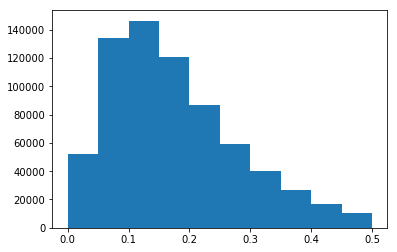

In [68]:
x = hlc_nsc_stars['sep_2d_arcsec_NSC_SDSS']
radius = 0.5
plt.hist(x[x<radius])

In [69]:
print('Found a match for ',np.sum(x<radius), '/',len(x),' SDSS standard stars within ',
      radius,' arcsec')

Found a match for  693857 / 905072  SDSS standard stars within  0.5  arcsec


In [73]:
# Save the cross-matched catalog 
fname = 'hlc_nsc_sdss_stars_matches'
np.save(fname,hlc_nsc_stars[x<0.5] )